## Assignment  no: 6
## Your name: Huda Aisyah Khoirunissa          student ID: 1144833
### When you use code, either from another student or an outside source, you should cite it. Tell me where the code comes from.
#### (v)  1. I Totally write by myself (都自己寫)
#### ( ) 2. Refer to other students (參考同學,註明姓名學號):   name and student id
#### ( ) 3. Refer to outside sources (參考外部資料網站), where:
## If you choose 2 or 3, tell me how similar you are. (如果選2,3, 請勾選相似程度)
#### ( ) < 25% ( ) 25%..50% ( ) 50%..75% (  ) > 75%
### Give me your expected score (給我你的期望分數): 87
### Reasons (理由): 
During this assignment, I built the entire model architecture, data pipeline, and training process myself without using a pretrained model. I tried several different approaches, including a custom CNN with skip connections, depthwise separable convolution, SE-block, and Spatial Attention, as well as tuning hyperparameters such as the optimizer, learning rate scheduler, and data augmentation. Although the process was quite challenging and required many retry attempts, I gained a deeper understanding of how to build a model from scratch without transfer learning, and how architecture and hyperparameters affect performance. I feel I put in my best effort, following all the assignment requirements ( StratifiedK-Fold, plotting, evaluation, and custom model implementation). Therefore, I expect to achieve a score of 87, commensurate with my effort and level of understanding. I tried to achieve good performance at least 60% it so difficult.

## If you use AI, you must clearly state what AI was used for and how it was used in your submission. Answer the following questions: (若有使用AI, 需說明AI使用的內容與方式, 回答底下問題)
- The tool you used (使用的AI工具名稱): ChatGPT 5.1 and Sonnet 4.5
- How you used it (lookup / debugging / code snippet) (使用的方式): I used AI as an assistant to help me understand concepts, check code logic, provide debugging advice when errors occurred, and ask for general guidance on CNN architecture, training pipelines, and hyperparameter tuning. I also used AI to request explanations and lookups for specific PyTorch functions (e.g., optimizer, learning rate scheduler, design blocks, etc.).
No code was copied directly from the AI, into the final submission—all parts of the model, training loop, and pipeline were written and adjusted based on my own understanding.
- How you modified and understood the result (修改與理解過程):
I only took very simple high-level ideas. I designed the actual model myself based on my own understanding, including adding attention mechanisms and skip connections. I adjusted and simplified the augmentations, fixed code that didn’t match the assignment, and removed anything not allowed (such as pretrained models). I debugged the errors by myself and rewrote the important parts independently. AI was used only for guidance, and the final implementation is my own work.

## 說明與心得 explain your code briefly, tell me something, and share your experience.

In this assignment, I built a custom CNN model entirely from scratch without using pretrained networks. I designed my own architecture using depthwise separable convolutions, skip connections, and attention mechanisms. Depthwise separable convolutions reduce parameters, skip connections stabilize training by improving gradient flow, and attention modules help the model focus on important features. I also used StratifiedKFold to ensure balanced train/validation splits and adjusted data augmentation to match the model’s complexity. Then, my networks is AtomCarsNet.

Throughout the process, I struggled with improving performance because training from scratch on the Stanford Cars dataset is difficult. I had to revise the model several times, fix errors, tune hyperparameters, and simplify parts of the pipeline. Even though it was challenging, I learned a lot about CNN design, debugging, and how different components affect training stability.

Overall, this assignment helped me understand deep learning more deeply, especially how to iteratively improve a custom model when the performance is not as expected.

### IMPORT & CONFIG

In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

if torch.cuda.is_available():
    DEVICE = "cuda"
elif torch.backends.mps.is_available():
    DEVICE = "mps"
else:
    DEVICE = "cpu"

print("Device:", DEVICE)

DATA_ROOT = r"C:\Users\numpppy\Downloads\Stanforddataset\car_data\car_data"
TRAIN_DIR = os.path.join(DATA_ROOT, "train")
TEST_DIR  = os.path.join(DATA_ROOT, "test")

BATCH_SIZE = 32
NUM_WORKERS = 0   
EPOCHS = 5
LR = 1e-3
VAL_SPLITS = 5    

Device: cuda


### DATASET, TRANSFORMS, DATALOADER

In [2]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

eval_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

class CarDataset(Dataset):
    def __init__(self, img_paths, labels, transform=None):
        self.img_paths = img_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = Image.open(self.img_paths[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

def load_paths_and_labels(root):
    class_dirs = sorted([
        d for d in os.listdir(root)
        if os.path.isdir(os.path.join(root, d))
    ])
    class_to_idx = {cls_name: i for i, cls_name in enumerate(class_dirs)}

    img_paths = []
    labels = []

    for cls in class_dirs:
        folder = os.path.join(root, cls)
        for fname in os.listdir(folder):
            path = os.path.join(folder, fname)
            if os.path.isfile(path):
                img_paths.append(path)
                labels.append(class_to_idx[cls])

    labels = np.array(labels, dtype=np.int64)
    return img_paths, labels, class_dirs

def build_loaders():
    train_img, train_label, class_names = load_paths_and_labels(TRAIN_DIR)
    test_img, test_label, _ = load_paths_and_labels(TEST_DIR)

    num_classes = len(class_names)

    skf = StratifiedKFold(
        n_splits=VAL_SPLITS,
        shuffle=True,
        random_state=42
    )
    train_idx, val_idx = next(skf.split(train_img, train_label))

    train_ds = CarDataset(
        [train_img[i] for i in train_idx],
        train_label[train_idx],
        transform=train_transform
    )
    val_ds = CarDataset(
        [train_img[i] for i in val_idx],
        train_label[val_idx],
        transform=eval_transform
    )
    test_ds = CarDataset(
        test_img,
        test_label,
        transform=eval_transform
    )

    train_loader = DataLoader(
        train_ds,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS
    )
    val_loader = DataLoader(
        val_ds,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS
    )
    test_loader = DataLoader(
        test_ds,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS
    )

    return train_loader, val_loader, test_loader, num_classes, class_names
    
train_loader, val_loader, test_loader, NUM_CLASSES, CLASS_NAMES = build_loaders()
x_batch, y_batch = next(iter(train_loader))
print("Train batch image shape:", x_batch.shape)
print("Train batch label shape:", y_batch.shape)
print("Num classes:", NUM_CLASSES)
print("Train samples:", len(train_loader.dataset))
print("Val samples:", len(val_loader.dataset))
print("Test samples:", len(test_loader.dataset))

Train batch image shape: torch.Size([32, 3, 224, 224])
Train batch label shape: torch.Size([32])
Num classes: 196
Train samples: 6515
Val samples: 1629
Test samples: 8041


### MODEL: AtomCarsNet (Custom CNN + Attention)

In [3]:
# 3. MODEL: AtomCarsNet (custom CNN + attention)

class SEBlock(nn.Module):
    def __init__(self, channels, reduction=8):
        super().__init__()
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.fc2 = nn.Linear(channels // reduction, channels)

    def forward(self, x):
        b, c, _, _ = x.size()
        w = F.adaptive_avg_pool2d(x, 1).view(b, c)
        w = F.relu(self.fc1(w), inplace=True)
        w = torch.sigmoid(self.fc2(w)).view(b, c, 1, 1)
        return x * w

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size // 2, bias=False)

    def forward(self, x):
        avg_map = torch.mean(x, dim=1, keepdim=True)
        max_map, _ = torch.max(x, dim=1, keepdim=True)
        attn = torch.cat([avg_map, max_map], dim=1)
        attn = torch.sigmoid(self.conv(attn))
        return x * attn

class AtomBlock(nn.Module):
    def __init__(self, in_c, out_c, stride=1):
        super().__init__()
        # conv 3x3
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_c)
        # depthwise separable conv
        self.dw    = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1, groups=out_c, bias=False)
        self.pw    = nn.Conv2d(out_c, out_c, kernel_size=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_c)
        self.se    = SEBlock(out_c, reduction=8)

        self.skip = None
        if in_c != out_c or stride != 1:
            self.skip = nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_c)
            )

        self.act = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x

        out = self.act(self.bn1(self.conv1(x)))
        out = self.dw(out)
        out = self.pw(out)
        out = self.bn2(out)
        out = self.act(out)
        out = self.se(out)

        if self.skip is not None:
            identity = self.skip(identity)

        out = self.act(out + identity)
        return out

class AtomCarsNet(nn.Module):
    def __init__(self, num_classes=196, dropout=0.4):
        super().__init__()

        self.stem = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.block1 = AtomBlock(64, 128, stride=1)
        self.block2 = AtomBlock(128, 256, stride=2)
        self.block3 = AtomBlock(256, 512, stride=2)
        self.block4 = AtomBlock(512, 512, stride=1)

        self.spatial_att = SpatialAttention(kernel_size=7)

        self.global_pool = nn.AdaptiveAvgPool2d(1)

        self.classifier = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(512, num_classes)
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0.0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        x = self.stem(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.spatial_att(x)
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model = AtomCarsNet(num_classes=NUM_CLASSES).to(DEVICE)
print("Trainable params:", count_parameters(model))

Trainable params: 5232918


### TRAINING & EVALUATION

In [4]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        running_correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = running_correct / total
    return epoch_loss, epoch_acc


@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        running_correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = running_correct / total
    return epoch_loss, epoch_acc

    
def train_model(model, train_loader, val_loader, epochs, lr, device, save_path="best_atomcarsnet.pth"):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }

    best_val_acc = 0.0

    for epoch in range(1, epochs + 1):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), save_path)

        scheduler.step()

        print(f"Epoch {epoch:02d}/{epochs} "
              f"- Train loss: {train_loss:.4f}, acc: {train_acc:.4f} "
              f"- Val loss: {val_loss:.4f}, acc: {val_acc:.4f}")

    return history, best_val_acc

### RUN TRAINING

Epoch 01/5 - Train loss: 5.3216, acc: 0.0080 - Val loss: 5.1865, acc: 0.0123
Epoch 02/5 - Train loss: 5.1715, acc: 0.0161 - Val loss: 5.1989, acc: 0.0209
Epoch 03/5 - Train loss: 5.0874, acc: 0.0227 - Val loss: 5.1517, acc: 0.0190
Epoch 04/5 - Train loss: 4.8850, acc: 0.0350 - Val loss: 4.9516, acc: 0.0338
Epoch 05/5 - Train loss: 4.8131, acc: 0.0388 - Val loss: 4.9061, acc: 0.0381
[0] Train Accuracy: 3.9%, Avg loss: 4.813116   Val Accuracy: 3.8%, Avg loss: 4.906143


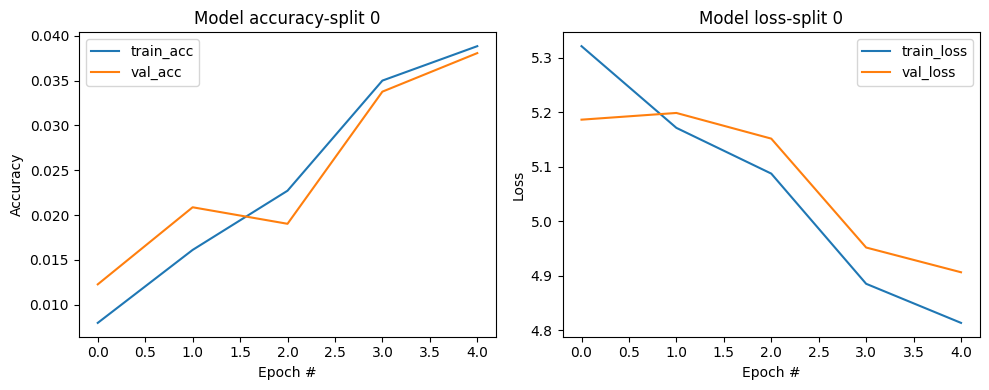

In [5]:
K = 5
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)

train_img, train_label, _ = load_paths_and_labels(TRAIN_DIR)
train_img = np.array(train_img)
train_label = np.array(train_label)

train_idx, val_idx = next(skf.split(train_img, train_label))

train_ds = CarDataset(train_img[train_idx], train_label[train_idx], transform=train_transform)
val_ds   = CarDataset(train_img[val_idx],   train_label[val_idx],   transform=eval_transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)

model = AtomCarsNet(num_classes=NUM_CLASSES).to(DEVICE)

history, best_val_acc = train_model(
    model,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    lr=LR,
    device=DEVICE
)

avg_train_acc  = history["train_acc"][-1] * 100
avg_val_acc    = history["val_acc"][-1] * 100
avg_train_loss = history["train_loss"][-1]
avg_val_loss   = history["val_loss"][-1]

print(f"[0] Train Accuracy: {avg_train_acc:.1f}%, Avg loss: {avg_train_loss:.6f}   "
      f"Val Accuracy: {avg_val_acc:.1f}%, Avg loss: {avg_val_loss:.6f}")

epochs_range = range(EPOCHS)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(epochs_range, history["train_acc"], label="train_acc")
plt.plot(epochs_range, history["val_acc"], label="val_acc")
plt.title("Model accuracy-split 0")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, history["train_loss"], label="train_loss")
plt.plot(epochs_range, history["val_loss"], label="val_loss")
plt.title("Model loss-split 0")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

### Final Evaluation on Test Set

In [6]:
criterion = nn.CrossEntropyLoss()

best_model = AtomCarsNet(num_classes=NUM_CLASSES).to(DEVICE)
best_model.load_state_dict(torch.load("best_atomcarsnet.pth", map_location=DEVICE))

test_loss, test_acc = evaluate(best_model, test_loader, criterion, DEVICE)

print(f"Test Accuracy: {test_acc * 100:.1f}%, Avg loss: {test_loss:.6f}")

Test Accuracy: 4.2%, Avg loss: 4.926882
